# Prepocessing dataset

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import tqdm.notebook as tq
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import RobertaTokenizer
from transformers import AdamW

from src.preprocessor import balancing_multiple_classes
from src.config_train import *
from src.roberta.roberta_tokenizer import TokenizedDataset
from src.roberta.roberta_model import RobertaClassification

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',None)

In [3]:
data_dir =  os.path.join(os.path.sep.join(os.getcwd().split(os.path.sep)[:-1]), "data")

In [4]:
df_train = pd.read_csv(os.path.join(data_dir,"dataset.csv")).loc[lambda x: x["emotion"] != "neutral"]
df_test = pd.read_csv(os.path.join(data_dir,"test_set.csv"))

In [5]:
df_train.head(5)

,sentence,emotion
0,I just do not know i feel like i am just way to paranoid i want to trust but its hard been hurt way to many times .,fear
1,I want to be with him so bad that i feel i am being tortured right now .,anger
2,I spent most of the day alone and several hours feeling unimportant because we were going to hang out together but nothing happened .,sadness
3,I am feeling so horny that i will make love to you if you are here and let you shoot in me hoping that my egg and your sperm can unite .,happiness
4,I do love feeling all clever when i do understand what they are saying .,happiness


In [6]:
# Cleaning
df_train.drop_duplicates(keep='first',inplace=True)
df_train.dropna(inplace=True)
df_train["emotion"].value_counts()

emotion
happiness    224422
sadness      143454
anger         77918
fear          59695
surprise      35989
disgust        5550
Name: count, dtype: int64

In [7]:
df_balanced = balancing_multiple_classes(df_train,'emotion')
df_balanced['emotion'].value_counts()

emotion
happiness    5550
sadness      5550
anger        5550
fear         5550
surprise     5550
disgust      5550
Name: count, dtype: int64

In [8]:
emotion_dummies_train = pd.get_dummies(df_train['emotion'])
emotion_dummies_train = emotion_dummies_train.astype(int)

emotion_dummies_test = pd.get_dummies(df_test['emotion'])
emotion_dummies_test = emotion_dummies_test.astype(int)

In [9]:
df_train_main = pd.concat([df_train['sentence'], emotion_dummies_train], axis=1)
df_test_main = pd.concat([df_test['sentence'], emotion_dummies_test], axis=1)

df_test_main.head(4)

,sentence,anger,disgust,fear,happiness,sadness,surprise
0,Girls are happy when they get flowers,0,0,0,1,0,0
1,His jaw dropped in disbelief when he saw the price of the concert tickets.,0,0,0,0,0,1
2,Sometimes the ugly stench makes me wanna throw up.,0,1,0,0,0,0
3,The foul odor from the garbage bin was disgusting.,0,1,0,0,0,0


In [10]:
sample = df_train_main.sample(n = 1000, random_state = 4)
columns = sample.columns
freq = sample[columns[2:]].sum()/sample.shape[0]
freq

disgust      0.015
fear         0.116
happiness    0.394
sadness      0.265
surprise     0.063
dtype: float64

In [11]:
sample.head()

,sentence,anger,disgust,fear,happiness,sadness,surprise
528526,Well . . . perhaps you should think about it .,1,0,0,0,0,0
126699,Haha if only he had reddit,0,0,0,1,0,0
324090,i feel good and am gaining weight much better than i did with diego,0,0,0,1,0,0
482598,i am feeling a bit unsure of myself as i document the beautiful birth of my fourth child,0,0,1,0,0,0
502760,i feel so disgusted as i type this,1,0,0,0,0,0


# RoBERTa Multi-class text classification

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
training_df, validation_df = train_test_split(df_train_main, random_state=77, test_size=0.30, shuffle=True)
testing_df = df_test_main.copy()

In [14]:
print(f"Train: {training_df.shape}, Val: {validation_df.shape}, Test: {testing_df.shape}")

Train: (382919, 7), Val: (164109, 7), Test: (1436, 7)


In [15]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [16]:
test_text = training_df['sentence'].sample().iloc[0]

encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")

print(f"original sentence: \n{test_text}\n")
print(f"tokenized sentence: \n{encodings}")

original sentence: 
When my brother ( 5 th in the family ) passed away .

tokenized sentence: 
{'input_ids': tensor([[   0, 1779,  127, 2138,   36,  195, 3553,   11,    5,  284, 4839, 1595,
          409,  479,    2,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}


In [17]:
emotion_list = emotion_dummies_train.columns.tolist()
emotion_list

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [18]:
train_dataset = TokenizedDataset(df_train_main, tokenizer, MAX_LEN, emotion_list)
val_dataset = TokenizedDataset(validation_df, tokenizer, MAX_LEN, emotion_list)
test_dataset = TokenizedDataset(testing_df, tokenizer, MAX_LEN, emotion_list)

In [19]:
next(iter(test_dataset))

{'input_ids': tensor([    0, 33722,    32,  1372,    77,    51,   120,  7716,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [20]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [21]:
num_labels = len(emotion_list)
model = RobertaClassification(num_labels=num_labels)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClassification(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
               

In [23]:
def train_model(training_loader, model, optimizer, loss_fn, device):
    """
    Train the model for one epoch.

    Args:
    training_loader (DataLoader): DataLoader for training data.
    model (torch.nn.Module): The model to be trained.
    optimizer (torch.optim.Optimizer): Optimizer for the model.
    loss_fn (callable): Loss function.
    device (torch.device): The device tensors will be allocated to.

    Returns:
    tuple: A tuple containing:
        - model (torch.nn.Module): The trained model.
        - float: The accuracy of the model on the training set.
        - float: The average loss over the training set.
    """

    print("Training:")
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                   leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        emotions = data['emotion'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask)
        loss = loss_fn(outputs, emotions)
        losses.append(loss.item())

        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim 
        _, emotion = torch.max(emotions, dim=1)  # batch dim
        num_samples += len(emotion)
        correct_predictions += torch.sum(preds==emotion)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # grad descent step
        optimizer.step()


        # Update progress bar
        loop.set_description('Training')
        loop.set_postfix(loss=loss.item(), acc=float(correct_predictions) / num_samples)

    return model, float(correct_predictions) / num_samples, np.mean(losses)

In [24]:
def eval_model(validation_loader, model, loss_fn, device):
    """
    Evaluate the model on the validation set.

    Args:
    validation_loader (DataLoader): DataLoader for validation data.
    model (torch.nn.Module): The model to be evaluated.
    loss_fn (callable): Loss function.
    device (torch.device): The device tensors will be allocated to.

    Returns:
    tuple: A tuple containing:
        - float: The accuracy of the model on the validation set.
        - float: The average loss over the validation set.
    """

    print("Evaluating:")
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.eval()
    loop = tq.tqdm(enumerate(validation_loader), total=len(validation_loader),
                   leave=True, colour='#8B0000')

    with torch.no_grad():
        for batch_idx, data in loop:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            emotions = data['emotion'].to(device, dtype=torch.float)

            outputs = model(ids, mask)
            loss = loss_fn(outputs, emotions)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            _, emotion = torch.max(emotions, dim=1)
            num_samples += len(emotion)
            correct_predictions += torch.sum(preds == emotion)

            # Update progress bar
            loop.set_description('Evaluating')
            loop.set_postfix(loss=loss.item(), acc=float(correct_predictions) / num_samples)

    return float(correct_predictions) / num_samples, np.mean(losses)


# Model Training

In [33]:
# Initialize a dictionary to store training and validation history
history = defaultdict(list)
best_accuracy = 0

# Loop over all epochs
for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')
    
    # Train the model
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer, loss_fn, device)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer, loss_fn, device)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join("models","roberta_model.bin"))
        best_accuracy = val_acc

Epoch 1/1
Training:


  0%|          | 0/14232 [00:00<?, ?it/s]

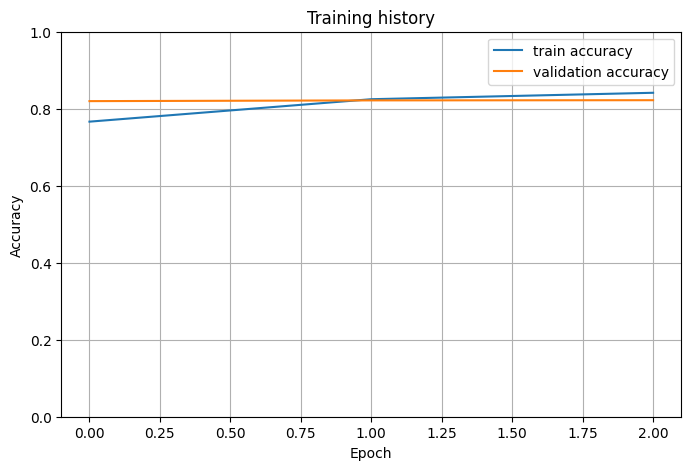

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [13]:
def get_predictions(model, data_loader):
    """
    Obtain predictions from a model based on the input from a data loader.

    This function processes batches of sentences from the data loader, performs
    predictions using the provided model, and gathers the outputs including sentences,
    predictions, prediction probabilities, and emotion values.

    Args:
        model (torch.nn.Module): The model to use for predictions, expected to be in evaluation mode.
        data_loader (DataLoader): A PyTorch DataLoader containing the dataset for prediction.

    Returns:
        tuple: A tuple containing four lists:
            - sentences (list[str]): The original sentences from the data loader.
            - predictions (list[int]): The predicted class indices for each sentence.
            - prediction_probs (list[list[float]]): The probabilities for each class for each sentence.
            - emotion_values (list[int]): The emotion values extracted from the dataset.
    """
    model.eval()

    sentences = []
    predictions = []
    prediction_probs = []
    emotion_values = []

    with torch.no_grad():
        for data in data_loader:
            sentence = data["sentence"]
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            emotions = data["emotion"].to(device, dtype=torch.float)

            outputs = model(ids, mask)
            _, preds = torch.max(outputs, dim=1)
            _, emotion = torch.max(emotions, dim=1)

            sentences.extend(sentence)
            predictions.extend(preds.tolist())  # Convert tensor to list
            prediction_probs.extend(outputs.tolist())  # Convert tensor to list
            emotion_values.extend(emotions.argmax(dim=1).tolist())  # Convert tensor to list

    return sentences, predictions, prediction_probs, emotion_values

In [36]:
sentences, predictions, prediction_probs, emotion_values = get_predictions(model, test_data_loader)

In [37]:
print(classification_report(emotion_values, predictions, target_names=emotion_list))

              precision    recall  f1-score   support

       anger       0.89      0.87      0.88       253
     disgust       0.86      0.95      0.90       199
        fear       0.86      0.93      0.89       215
   happiness       0.96      0.95      0.95       263
     sadness       0.94      0.82      0.88       289
    surprise       0.88      0.91      0.89       217

    accuracy                           0.90      1436
   macro avg       0.90      0.90      0.90      1436
weighted avg       0.90      0.90      0.90      1436


In [39]:
emotion_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5}

predicted_emotions = [emotion for label in predictions for emotion, encoded_label in emotion_mapping.items() if label == encoded_label]

print('F1 score on test set: {}'.format(f1_score(df_test['emotion'], predicted_emotions, average='weighted')))

F1 score on test set: 0.8987679248718544
